
# Ehlers Cybernetic analysis for stocks and futures
## Chapter 2

In [12]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 7

In [13]:
# Import some useful libraries and tools
import pandas as pd
import numpy as np
from scipy import signal
from numpy import pi

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [14]:
def bode_plot(h, w, plot_title='Bode plot'):
    """
    Bode amplitude and phase plot function
    """
    dB = 20 * np.log10(abs(h))
    phi = np.unwrap(np.angle(h))
    
#    lag = - (phi / 360) * (2.0 / (w / pi)) 
    
    w_ = w / (2 * pi)     # Set frequency in Cycles per day.
    fig, axs = plt.subplots(2, 1, sharex=True)

    plt.suptitle(plot_title, fontsize=16)
    
    axs[0].plot(w_, dB, 'b')
    axs[0].set_ylabel('Amplitude (dB)', color='b', fontsize=14)
    axs[0].grid()
        
    axs[1].plot(w_, phi, 'g')
    axs[1].set_ylabel(r'$\phi $ (deg)', color='g', fontsize=14)
    axs[1].set_xlabel('Frequency (Cycles per day)', fontsize=12)
    axs[1].set_xlim(xmax = 0.5)
    axs[1].grid()
    plt.show()

Defining:
$$y[n - 1] = y[n]z^{-1}\\$$
Then the EMA can be expresed as:
$$
\\y[n] = \alpha x[n] + (1 - \alpha ) y[n-1]\\
\\y[n]\left ( 1 - (1 - \alpha ) z^{-1}\right ) = \alpha x[n]\\
$$
And the impulse-response function:
$$
\\H(z) = \frac{y[n]}{x[n]} = \frac{\alpha} {1 - (1 - \alpha ) z^{-1}}\\
$$
Now following the [instruccions](http://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#analysis-of-linear-systems) to define a Difference-equation filtering:

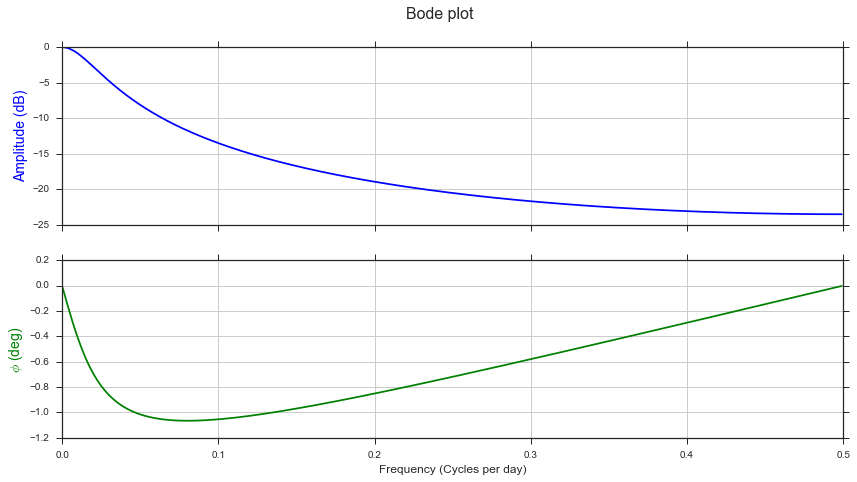

In [15]:
# Define an SMA lag and the equivalent EMA alpha.
SMA_lag = 15
alpha = 2.0 / (SMA_lag + 1)                            # alpha=0.05 in the book's examples.

# Now define the Scipy signal model
EMA_numerator = np.array([alpha])                          # Input coefficients, H(z) numerator.
EMA_denominator = np.array([1.0, -(1.0 - alpha)])          # Output coefficients H(z) denominator.

w, h = signal.freqz(EMA_numerator, EMA_denominator)        # Here is where magic happens!

# Now plot the Amplitude response and the phase shift response graphs.
bode_plot(h, w)

In page 12:
> The high-frequency attenuation of the low-pass filter of Equation 2.2 is not infinite (i.e., the transfer response is 0) at the Nyquist frequency. A finite high-frequency response in the low-pass filter will lead to a gain error in the transfer response of the high-pass filter. The finite attenuation problem is eliminated by averaging two sequential input samples rather than using only a single input sample.

Then the function can be expressed as:
$$\\y[n]\left ( 1 - (1 - \alpha ) Z^{-1}\right ) = \frac{\alpha}{2}(1 + Z^{-1}) x[n]\>\>\>\>\>(1)\\$$

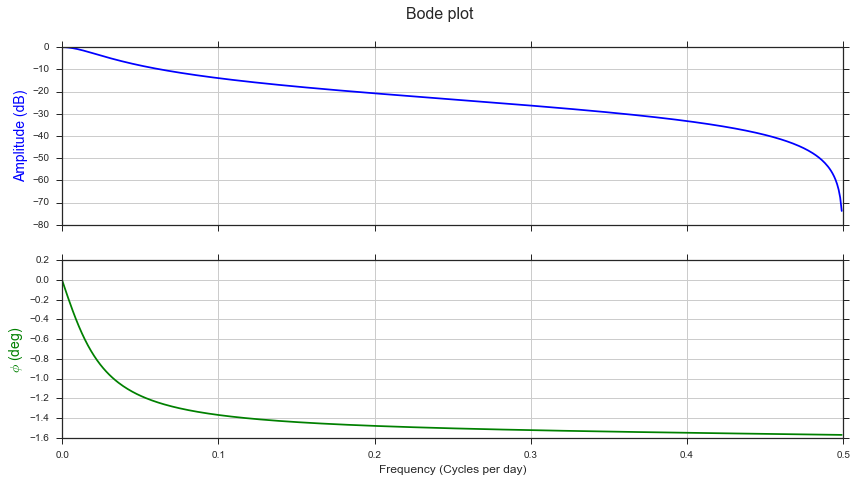

In [16]:
numerator = np.array([alpha / 2.0, alpha / 2.0])
denominator = np.array([1.0, -(1.0 - alpha)])

w, h = signal.freqz(numerator, denominator)
bode_plot(h, w)

Now substract the equation (1) in the impulse-response form from unity, in order to construct a high-pass filter.

$$
\\H(z) = \frac{y[n]}{x[n]} = \frac{\frac{\alpha}{2} (1 + z^{-1})} {1 - (1 - \alpha ) z^{-1}}\\
\\1-H(z)= \frac{\left (1-\frac{\alpha}{2}   \right ) (1 + z^{-1})} {1 - (1 - \alpha ) z^{-1}}\>\>\>\>\>(2)\\
$$
In page 15:
> A second-order Gaussian low-pass filter can be generated by taking an EMA and immediately taking another identical EMA of the first EMA. This can be represented by squaring the transfer response. We can therefore obtain a second-order Gaussian high-pass filter response by squaring\* Equation (2)...

$$
\\H(z)= \frac{\left (1-\frac{\alpha}{2}\right)^2 (1 - 2z^{-1} + z^{-2})}
{1 - 2(1 - \alpha ) z^{-1}+(1 - \alpha )^2 z^{-2}}\>\>\>\>\>(3)\\
$$

\*Convolution in the time domain is product in the z space.

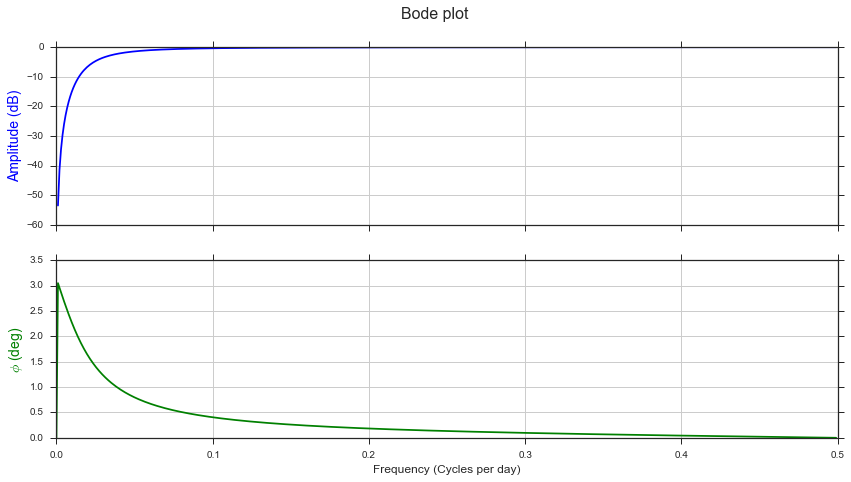

In [17]:
# Auxiliar variables.
a_ = (1 - alpha / 2.0)**2
b_ = (1 - alpha)

numerator = np.array([a_, -2 * a_, a_])
denominator = np.array([1.0, -2 * b_, b_ ** 2])

w, h = signal.freqz(numerator, denominator)
bode_plot(h, w)

Now substract equation (3) from unity to produce the Instantaneous Trendline

$$
\\IT(z)= \frac{\left (\alpha-\frac{\alpha^2}{4}\right) + \frac{\alpha^2}{2}z^{-1} - \left (\alpha-\frac{3\alpha^2}{4}\right) z^{-2}}
{1 - 2(1 - \alpha ) z^{-1}+(1 - \alpha )^2 z^{-2}} \>\>\>\>\>(4) \\
$$

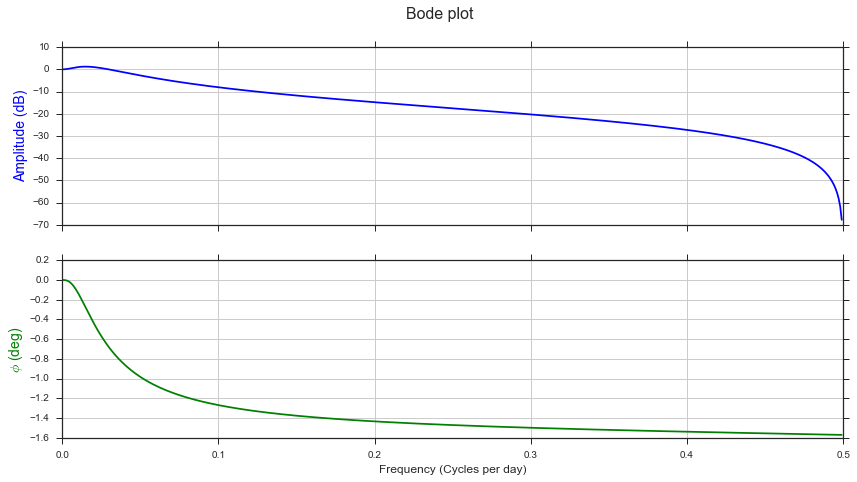

In [18]:
a_ = (alpha / 2.0) ** 2

IT_numerator = np.array([alpha - a_, 2 * a_, -(alpha - 3 * a_)])
IT_denominator = np.array([1.0, -2 * b_, b_ ** 2])

w, h = signal.freqz(IT_numerator, IT_denominator)
bode_plot(h, w)

In [19]:
# Now load some data, specifically AAPL minute data from 2015-07-14
df = pd.read_csv('https://drive.google.com/uc?export=download&id=0B9-kA56h5JCMbXptY0kyVXZXaUU',
                 index_col=0, parse_dates=True)
x = df.CLOSE.as_matrix()

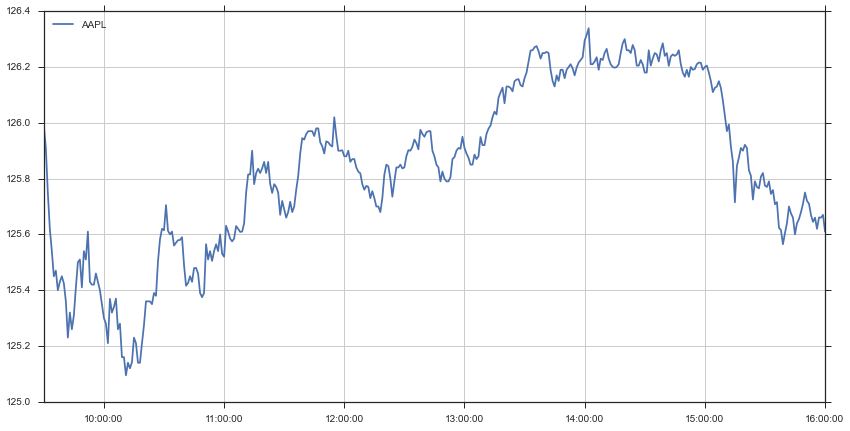

In [20]:
plt.plot(df.index, x, label = 'AAPL')
plt.legend(loc='upper left')
plt.grid()

In [21]:
# Now etimate the actual indicators from the filters with real data
# EMA IIR filter
zi = signal.lfiltic(EMA_numerator, EMA_denominator, y=x, x=x)  # Filter initial conditions.
EMA = signal.lfilter(EMA_numerator, EMA_denominator, x, zi=zi) # Difference-equation filtering.

# IT IIR filter
zi = signal.lfiltic(IT_numerator, IT_denominator, y=x, x=x)  
IT = signal.lfilter(IT_numerator, IT_denominator, x, zi=zi)

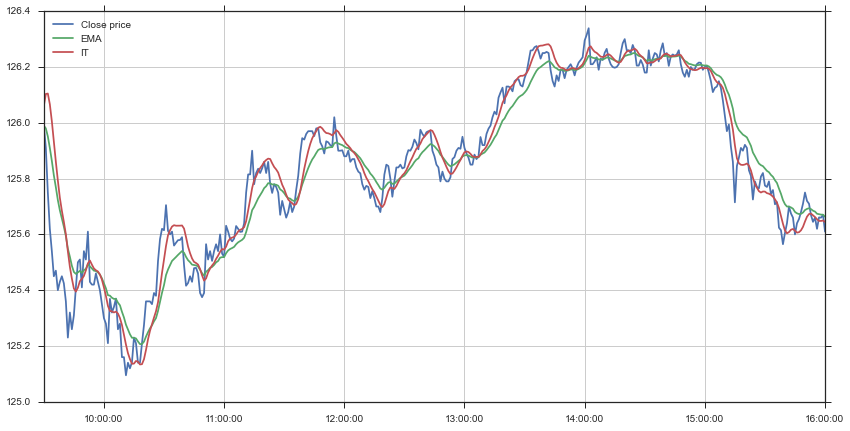

In [22]:
plt.plot(df.index, x, label='Close price')
plt.plot(df.index, EMA[0], label='EMA')
plt.plot(df.index, IT[0], label='IT')
plt.grid()
plt.legend(loc='upper left')